# Pre-process the in-situ data
This notebook was run for each dataset (defined by `campagne`) and executes following steps:
* Reads in the in-situ LISST-200X and OBS data (available on [MDA](https://doi.org/10.14284/572))
* Correct the depth coordinate of the in-situ measurements to Lowest Astronomical Tide (LAT) using tide correction data from the vessel's underway data system and hydrographical data from [MDK](https://www.agentschapmdk.be/en/hydrographical-data).
* Visual inspection of the grain size distributions to:
    * remove of erroneous size classes and recalculate the Total Volume Concentration if required.
    * determine the boundaries for grain size populations
* Calculate grain size statistics using a python translation of the [G2Sd R package](https://cran.r-project.org/web/packages/G2Sd/), itself based on Gradistat (Blott and Pye, 2001).
* Export the pre-processed in-situ data to a new CSV file


In [1]:
from timbers_code.grainsize import get_grainsize_stats, get_size_class_assemblages
import pandas as pd
from glob import glob
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib import colors, cm

## Set the input parameters
* campagne: name of the campagne for which to process the data
* lisst_size_classes: path to the file that defines the size classes. From LISST-200X Manual
* lisst_file: path to the input in-situ data file for the campagne. Data also available in https://doi.org/10.14284/572 
* datetime_columns: list of column headers that define the timestamp
* sample_interval: sample interval of LISST-200X, used to resample the tide correction
* z_coord: the header for the input depth to use for tide correction
* z_coord_LAT: the header for the tide corrected depth (in LAT)
* tide_correction_files: file paths to tide correction tables based on RTK data from the vessel
* tidefile_sonarscope: file paths to the tide correction files exported from Sonarscope and used for MBES data for comparison
* size_bins_to_remove: list of Erroneous size classes to remove from data
* bin_boundaries: list of grain size boundaries used to calculate TVC for different grain size populations
* output_file: path to the processed LISST-200X file for the campagne

In [2]:
# input parameters
campagne = '21-550_KW'
lisst_size_classes = 'sensor_data/lisst_size_classes.csv'
lisst_file=f'sensor_data/Timbers_{campagne}/Sensors_{campagne}.csv'
datetime_columns = ['year', 'Month', 'day', 'hour', 'minute', 'second']
sample_interval = '1s'
z_coord = 'Depth in calibrated units [m]'
z_coord_LAT = 'Lisst_depth_m_LAT'
tide_correction_files = glob('sensor_data/TideCorrection/Waterniveau_LAT_*.xlsx')
tidefile_sonarscope = 'sensor_data/TideCorrection/TideFiles/TideFromRTK_{}_ALL.txt'.format(campagne.replace('_WD','').replace('_KW',''))
# grain size parameters
## Erroneous size classes (see plots below)
### for 21-092 ==> [1,2,3,4,31,32,33,34,35,36]
### for 21-160 ==> [31,32,33,34,35,36]
size_bins_to_remove = []
## TVC assemblage boundaries
### bin_boundaries = np.array([15.,200.]) # set boundaries according to Fettweis et al., 2014
bin_boundaries = np.array([3.,20.,200.]) # set boundaries according to Lee et al., 2012
# output files
output_file = f'sensor_data/Timbers_{campagne}/Sensors_{campagne}_w_grainsize_tide_corrected.csv'

## Read in in-situ data

In [3]:
df = pd.read_csv(lisst_file)
# calculate datetime field from datetime_columns
df['datetime'] = pd.to_datetime(df[datetime_columns])
df

,Volume conc (microl/l) 1,Volume conc (microl/l) 2,Volume conc (microl/l) 3,Volume conc (microl/l) 4,Volume conc (microl/l) 5,Volume conc (microl/l) 6,Volume conc (microl/l) 7,Volume conc (microl/l) 8,Volume conc (microl/l) 9,Volume conc (microl/l) 10,...,Time,VPR lat,VPR long,VPR depth,majoraxis,minoraxis,angle,devz,linename,datetime
0,0.0,0.0,0.0039,0.0276,0.0878,0.0717,0.0229,0.0105,0.0152,0.0236,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-09 09:48:10
1,0.0,0.0,0.0000,0.0000,0.0221,0.0718,0.0172,0.0062,0.0186,0.0527,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-09 09:48:11
2,0.0,0.0,0.0000,0.0016,0.0370,0.0745,0.0197,0.0079,0.0191,0.0449,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-09 09:48:12
3,0.0,0.0,0.0000,0.0094,0.0685,0.0769,0.0206,0.0083,0.0150,0.0284,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-09 09:48:13
4,0.0,0.0,0.0000,0.0015,0.0354,0.0763,0.0205,0.0081,0.0195,0.0454,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-09 09:48:14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3094,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0012,0.0417,...,2021-07-09 10:39:44+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-09 10:39:44
3095,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0492,...,2021-07-09 10:39:45+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-09 10:39:45
3096,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0043,...,2021-07-09 10:39:46+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-09 10:39:46
3097,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0344,...,2021-07-09 10:39:47+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-09 10:39:47


## Convert LISST-200X depth measurement to meter LAT (Lowest Astronomical Tide)

### Read in tide correction files

In [4]:
tide_df = pd.concat(map(lambda file: pd.read_excel(file, parse_dates=[0]),tide_correction_files))
tide_df.set_index('datum & tijd', inplace = True)
tide_df

,lat,long,hoogte RTK antenne,geoidale scheiding,draught (cm),waterniveau LAT,Unnamed: 7,Unnamed: 8
datum & tijd,,,,,,,,
2020-10-05 00:00:00,51.226400,2.935637,10.48,47.15,346.5,3.989,NaN,NaN
2020-10-05 00:00:01,51.226400,2.935637,10.47,47.15,346.5,3.979,NaN,NaN
2020-10-05 00:00:01,51.226400,2.935638,10.47,47.15,346.5,3.979,NaN,NaN
2020-10-05 00:00:02,51.226400,2.935638,10.47,47.15,346.5,3.979,NaN,NaN
2020-10-05 00:00:03,51.226400,2.935638,10.47,47.15,347.2,3.986,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-07-09 21:59:55,51.226388,2.935655,9.31,47.15,375.1,3.105,NaN,NaN
2021-07-09 21:59:55,51.226388,2.935655,9.32,47.15,375.1,3.115,NaN,NaN
2021-07-09 21:59:57,51.226388,2.935655,9.31,47.15,375.2,3.106,NaN,NaN


### Process LAT level
* resample to LISST-200X sample interval & average
* interpolate to remove missing values
* smooth with a Butterworth filter, with order 2 and normalized cutoff frequency of 1/200

In [5]:
tide_proc = tide_df[['waterniveau LAT']].resample(sample_interval).mean().interpolate(method='time')
butt_filter = signal.butter(N = 2, Wn = 1/200, btype = 'lowpass', output='sos')
tide_proc['waterniveau LAT smooth'] = signal.sosfilt(butt_filter, tide_proc['waterniveau LAT'])

### Read in sonarscope tidefile to compare

In [6]:
tide_sonarscope = pd.read_csv(tidefile_sonarscope, sep = '  ', names = ['Date','Time','Sonarscope LAT correction'])
tide_sonarscope['Sonarscope LAT correction'] = -1*tide_sonarscope['Sonarscope LAT correction']
tide_sonarscope.index = pd.to_datetime(tide_sonarscope.Date + ' ' + tide_sonarscope.Time, format='%d/%m/%Y %H:%M:%S.%f')
tide_sonarscope_proc = tide_sonarscope[['Sonarscope LAT correction']].resample(sample_interval).mean().interpolate(method='time')

c:\Users\nore.praet\Anaconda3\envs\pcp-env2\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


### Merge the LAT tide correction * sonarscope tide correction to the LISST FILE

In [7]:
df = df.merge(tide_proc, how = 'left', left_on = 'datetime', right_index = True).merge(tide_sonarscope_proc, how = 'left', left_on = 'datetime', right_index = True)

In [8]:
df

,Volume conc (microl/l) 1,Volume conc (microl/l) 2,Volume conc (microl/l) 3,Volume conc (microl/l) 4,Volume conc (microl/l) 5,Volume conc (microl/l) 6,Volume conc (microl/l) 7,Volume conc (microl/l) 8,Volume conc (microl/l) 9,Volume conc (microl/l) 10,...,VPR depth,majoraxis,minoraxis,angle,devz,linename,datetime,waterniveau LAT,waterniveau LAT smooth,Sonarscope LAT correction
0,0.0,0.0,0.0039,0.0276,0.0878,0.0717,0.0229,0.0105,0.0152,0.0236,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-09 09:48:10,3.231,3.265943,NaN
1,0.0,0.0,0.0000,0.0000,0.0221,0.0718,0.0172,0.0062,0.0186,0.0527,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-09 09:48:11,3.211,3.266287,NaN
2,0.0,0.0,0.0000,0.0016,0.0370,0.0745,0.0197,0.0079,0.0191,0.0449,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-09 09:48:12,3.291,3.266616,NaN
3,0.0,0.0,0.0000,0.0094,0.0685,0.0769,0.0206,0.0083,0.0150,0.0284,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-09 09:48:13,3.311,3.266940,NaN
4,0.0,0.0,0.0000,0.0015,0.0354,0.0763,0.0205,0.0081,0.0195,0.0454,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-09 09:48:14,3.221,3.267261,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3094,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0012,0.0417,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-09 10:39:44,4.209,4.176137,4.160950
3095,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0492,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-09 10:39:45,4.119,4.176428,4.161084
3096,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0043,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-09 10:39:46,4.069,4.176700,4.161218
3097,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0344,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-09 10:39:47,4.139,4.176947,4.161352


### Calculate the lisst depth in m LAT

In [9]:
df[z_coord_LAT] = df['waterniveau LAT smooth'] - df[z_coord]
df['inverted '+z_coord] = -1*df[z_coord] # Calculate to check offset with initial assumption of depth

### Plot the correction

<AxesSubplot:xlabel='datetime'>

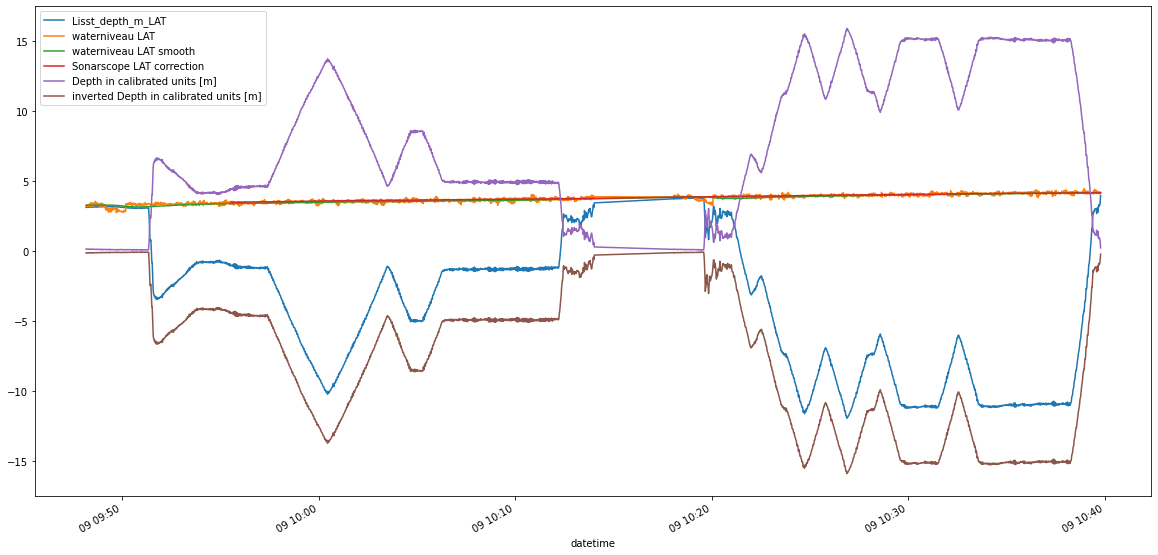

In [10]:
fig, ax = plt.subplots(figsize = (20,10))
df.set_index('datetime')[[z_coord_LAT,'waterniveau LAT','waterniveau LAT smooth','Sonarscope LAT correction',z_coord, 'inverted '+z_coord]].plot(ax = ax)
#ax.set_ylim(-1,1)

## Calculate grain size statistics from the LISST-200X size classes

### Read in size classes

In [11]:
size_classes = pd.read_csv(lisst_size_classes)
size_classes = size_classes.set_index('Size_bin')
# Assemblages are determined based on the Lower edge of the bin
size_classes['Assemblages'] = get_size_class_assemblages(size_classes=size_classes['Lower'], bin_boundaries=bin_boundaries)
size_classes

,Lower,Upper,Median,Assemblages
Size_bin,,,,
1,1.00,1.48,1.21,"(0.0, 3.0]"
2,1.48,1.74,1.60,"(0.0, 3.0]"
3,1.74,2.05,1.89,"(0.0, 3.0]"
4,2.05,2.42,2.23,"(0.0, 3.0]"
5,2.42,2.86,2.63,"(0.0, 3.0]"
6,2.86,3.38,3.11,"(0.0, 3.0]"
7,3.38,3.98,3.67,"(3.0, 20.0]"
8,3.98,4.70,4.33,"(3.0, 20.0]"
9,4.70,5.55,5.11,"(3.0, 20.0]"


### Plot the grain size distributions

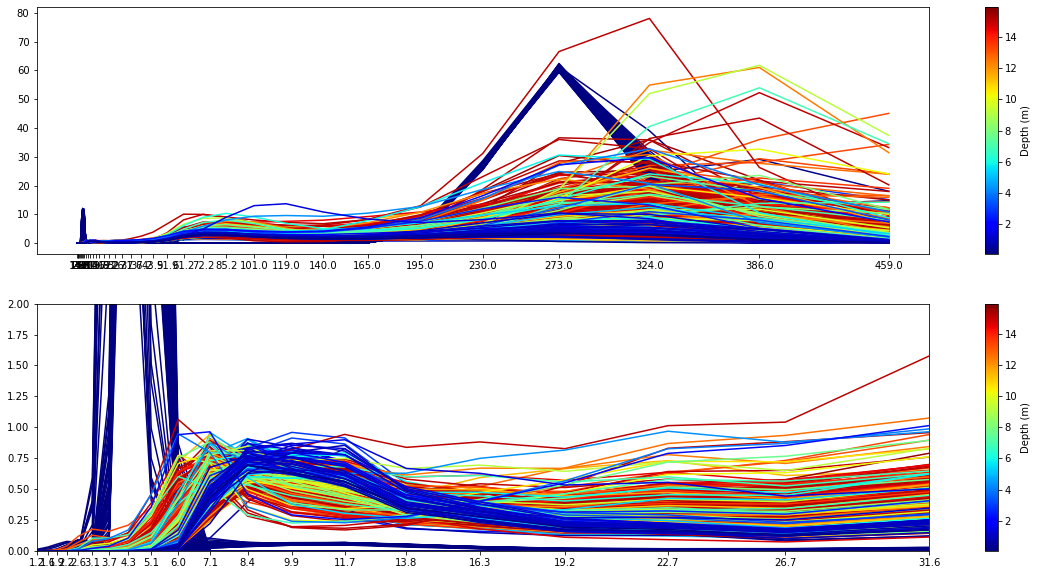

In [12]:
cmap = cm.ScalarMappable(norm=colors.Normalize(vmin=df['Depth in calibrated units [m]'].min(),
                                               vmax=df['Depth in calibrated units [m]'].max()),
                         cmap=cm.jet)
fig, ax = plt.subplots(2,figsize = (20,10))

# plot the full range
for volconc, depth in zip(df.loc[:,df.columns.str.contains('Volume conc')].iterrows(),df['Depth in calibrated units [m]']):
    ax[0].plot(size_classes['Median'], volconc[1], c=cmap.to_rgba(depth))
ax[0].set_xticks(size_classes['Median'])
fig.colorbar(cmap, ax=ax[0], label = 'Depth (m)')

# plot the lowest 20 size classes
for volconc, depth in zip(df.loc[:,df.columns.str.contains('Volume conc')].iterrows(),df['Depth in calibrated units [m]']):
    ax[1].plot(size_classes['Median'], volconc[1], c=cmap.to_rgba(depth))
ax[1].set_xticks(size_classes['Median'])
ax[1].set_xlim([1.21,31.60]) # lowest 20 size classes
ax[1].set_ylim([0,2])
fig.colorbar(cmap, ax=ax[1], label = 'Depth (m)')

### Remove erroneous size classes

In [13]:
# columns_to_remove = df.columns[df.columns.str.contains('Volume conc') & df.columns.str.contains('|'.join([str(i) for i in size_bins_to_remove]))]
# size_bins_to_remove is defined at top of cell
columns_to_remove = ['Volume conc (microl/l) {}'.format(str(size_bin)) for size_bin in size_bins_to_remove]
print(columns_to_remove)
df = df.drop(columns=columns_to_remove)
size_classes = size_classes.drop(index=size_bins_to_remove)

[]


### Recalculate the Total Volume Concentration with erroneous size classes removed

In [14]:
new_TVC = df[df.columns[df.columns.str.contains('Volume conc')]].sum(axis=1)
print(pd.concat([df['TVC_recal'],new_TVC], axis = 1)) # Check the difference
df['TVC_recal'] = new_TVC # overwrite

      TVC_recal        0
0       28.8940  41.7498
1       28.3470  37.6558
2       28.8095  39.1312
3       28.7663  40.6516
4       28.4666  38.8806
...         ...      ...
3094    27.9610  48.5069
3095    23.6033  30.3261
3096    22.7007  29.3031
3097    25.0347  35.6458
3098    21.5147  31.9865

[3099 rows x 2 columns]


### Replot the grainsize distributions after corrections

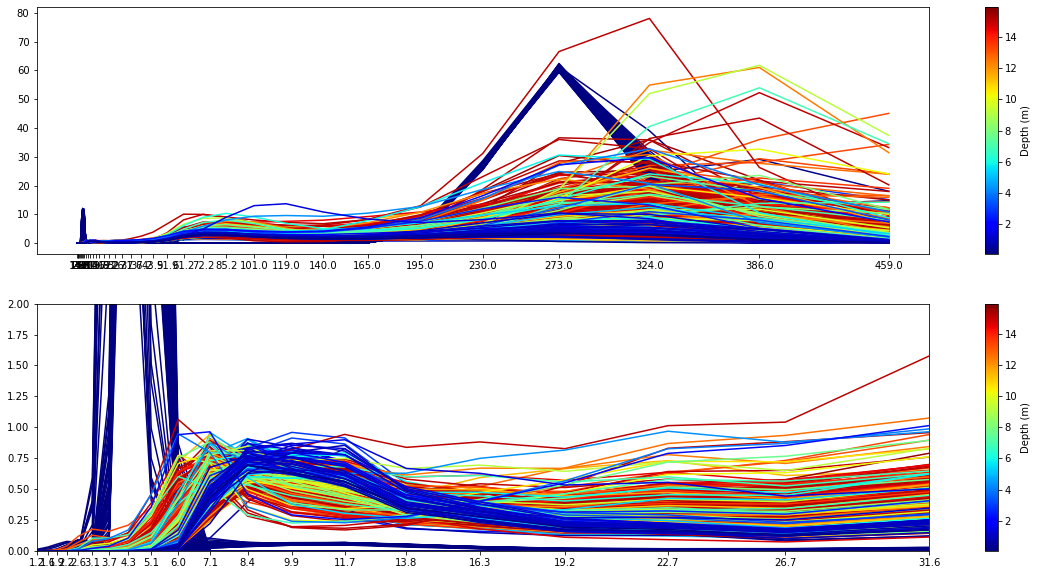

In [15]:
import matplotlib.pyplot as plt
from matplotlib import colors, cm
cmap = cm.ScalarMappable(norm=colors.Normalize(vmin=df['Depth in calibrated units [m]'].min(),
                                               vmax=df['Depth in calibrated units [m]'].max()),
                         cmap=cm.jet)
fig, ax = plt.subplots(2,figsize = (20,10))

# plot the full range
for volconc, depth in zip(df.loc[:,df.columns.str.contains('Volume conc')].iterrows(),df['Depth in calibrated units [m]']):
    ax[0].plot(size_classes['Median'], volconc[1], c=cmap.to_rgba(depth))
ax[0].set_xticks(size_classes['Median'])
fig.colorbar(cmap, ax=ax[0], label = 'Depth (m)')

# plot the lowest 20 size classes
for volconc, depth in zip(df.loc[:,df.columns.str.contains('Volume conc')].iterrows(),df['Depth in calibrated units [m]']):
    ax[1].plot(size_classes['Median'], volconc[1], c=cmap.to_rgba(depth))
ax[1].set_xticks(size_classes['Median'])
ax[1].set_xlim([1.21,31.60]) # lowest 20 size classes
ax[1].set_ylim([0,2])
fig.colorbar(cmap, ax=ax[1], label = 'Depth (m)')

### Determine the boundaries for grain size populations and plot

In [16]:
bin_boundaries = bin_boundaries[(bin_boundaries >= size_classes['Lower'].min()) & (bin_boundaries <= size_classes['Lower'].max())] # only get boundaries within the Median Size Classes
bin_boundaries

array([  3.,  20., 200.])

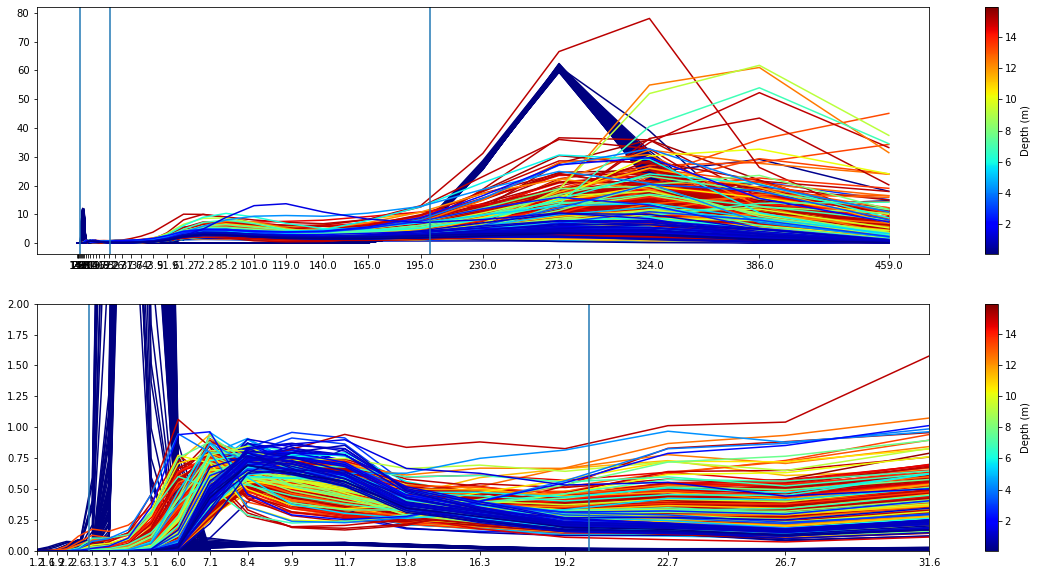

In [17]:
import matplotlib.pyplot as plt
from matplotlib import colors, cm
cmap = cm.ScalarMappable(norm=colors.Normalize(vmin=df['Depth in calibrated units [m]'].min(),
                                               vmax=df['Depth in calibrated units [m]'].max()),
                         cmap=cm.jet)
fig, ax = plt.subplots(2,figsize = (20,10))

# plot the full range
for volconc, depth in zip(df.loc[:,df.columns.str.contains('Volume conc')].iterrows(),df['Depth in calibrated units [m]']):
    ax[0].plot(size_classes['Median'], volconc[1], c=cmap.to_rgba(depth))
ax[0].set_xticks(size_classes['Median'])
[ax[0].axvline(x=bound) for bound in bin_boundaries] 
fig.colorbar(cmap, ax=ax[0], label = 'Depth (m)')

# plot the lowest 20 size classes
for volconc, depth in zip(df.loc[:,df.columns.str.contains('Volume conc')].iterrows(),df['Depth in calibrated units [m]']):
    ax[1].plot(size_classes['Median'], volconc[1], c=cmap.to_rgba(depth))
ax[1].set_xticks(size_classes['Median'])
ax[1].set_xlim([1.21,31.60]) # lowest 20 size classes
ax[1].set_ylim([0,2])
[ax[1].axvline(x=bound) for bound in bin_boundaries] 
fig.colorbar(cmap, ax=ax[1], label = 'Depth (m)')

### Run the grainsize statistics calculations on the volume concenration columns and add to table

In [18]:
gs_stats = df.loc[:,df.columns.str.contains('Volume conc')].apply(lambda x: get_grainsize_stats(x,
                                                                                                size_classes,
                                                                                                statistics_to_calculate = ['mode','indices','geometric moments', 'PSD slope', 'TVC assemblages'],  
                                                                                                bin_boundaries = bin_boundaries,
                                                                                                plot = False,
                                                                                                phi = False),axis = 1)
result = pd.concat([df, gs_stats], sort = False, axis = 1)
result

No volume concentrations found. Returning null values for all grainsize stats!
No volume concentrations found. Returning null values for all grainsize stats!
No volume concentrations found. Returning null values for all grainsize stats!
No volume concentrations found. Returning null values for all grainsize stats!
No volume concentrations found. Returning null values for all grainsize stats!
No volume concentrations found. Returning null values for all grainsize stats!
No volume concentrations found. Returning null values for all grainsize stats!
No volume concentrations found. Returning null values for all grainsize stats!
No volume concentrations found. Returning null values for all grainsize stats!
No volume concentrations found. Returning null values for all grainsize stats!
No volume concentrations found. Returning null values for all grainsize stats!
No volume concentrations found. Returning null values for all grainsize stats!
No volume concentrations found. Returning null value

,Volume conc (microl/l) 1,Volume conc (microl/l) 2,Volume conc (microl/l) 3,Volume conc (microl/l) 4,Volume conc (microl/l) 5,Volume conc (microl/l) 6,Volume conc (microl/l) 7,Volume conc (microl/l) 8,Volume conc (microl/l) 9,Volume conc (microl/l) 10,...,kurtosis_geom_um,mean_geom_um,mode_1,mode_2,mode_3,mode_4,mode_5,mode_6,skewness_geom_um,sorting_geom_um
0,0.0,0.0,0.0039,0.0276,0.0878,0.0717,0.0229,0.0105,0.0152,0.0236,...,10.969822,142.361126,230.0,85.2,2.63,11.7,NaN,NaN,-1.734640,1.895342
1,0.0,0.0,0.0000,0.0000,0.0221,0.0718,0.0172,0.0062,0.0186,0.0527,...,10.727974,134.870084,230.0,85.2,3.11,11.7,8.39,NaN,-1.727635,1.811597
2,0.0,0.0,0.0000,0.0016,0.0370,0.0745,0.0197,0.0079,0.0191,0.0449,...,10.773026,137.093133,230.0,85.2,3.11,9.9,NaN,NaN,-1.727694,1.828530
3,0.0,0.0,0.0000,0.0094,0.0685,0.0769,0.0206,0.0083,0.0150,0.0284,...,10.712573,140.278934,230.0,85.2,3.11,11.7,NaN,NaN,-1.692545,1.861647
4,0.0,0.0,0.0000,0.0015,0.0354,0.0763,0.0205,0.0081,0.0195,0.0454,...,10.555158,137.057479,230.0,85.2,3.11,NaN,NaN,NaN,-1.687210,1.834077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3094,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0012,0.0417,...,3.880117,133.305473,324.0,72.2,9.90,NaN,NaN,NaN,-1.072960,2.629595
3095,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0492,...,3.660790,92.979595,72.2,273.0,8.39,NaN,NaN,NaN,-1.022491,2.661870
3096,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0043,...,3.460247,94.273824,230.0,72.2,11.70,NaN,NaN,NaN,-1.043755,2.641363
3097,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0344,...,3.924797,108.441636,273.0,72.2,8.39,NaN,NaN,NaN,-1.093726,2.593426


## Write out the processed in-situ data

In [19]:
result.to_csv(output_file, index=False)